# **Lab 3: Approximation**
**Martin Börjeson**

# **Abstract**

In this lab I implemented an L2-projection algorithm in 1 dimension. I used my own code from previous labs for things such as solving matrix equations. The numpy library was also utilized.

#**About the code**

The code is written by me, Martin Börjeson.

In [107]:
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# Report by Martin Börjeson

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

I used my implementation of the $Ax = b$ solver from lab1 in this lab.

In [108]:
# Load neccessary modules.
import numpy as np

from matplotlib import pyplot as plt

def modified_gram_schmidt_iteration(A: np.ndarray):
  dims = A.shape
  if(dims[0] != dims[1]):
    raise Exception("Matrix is not quadratic!")
  if(np.linalg.matrix_rank(A)!=A.shape[0]):
    raise Exception("Matrix is singular!")
  A = np.copy(A)
  n = dims[0]
  R = np.zeros(A.shape, dtype = float)
  Q = np.zeros(A.shape, dtype = float)
  for j in range(n):
    v = A[:,j]
    for i in range(j):
      R[i,j] = np.dot(Q[:,i],v)
      v -= R[i,j]*Q[:,i]
    R[j,j] = np.linalg.norm(v)
    Q[:,j] = v/R[j,j]
  return Q,R

def backward_substitution(R: np.ndarray, v: np.ndarray) -> np.ndarray:
  n = v.shape[0]
  x = np.zeros(v.shape, dtype = float)
  x[-1] = v[-1]/R[-1,-1]
  for i in range(n-2,-1,-1):
    sum = 0
    for j in range(i+1,n):
      sum += R[i,j]*x[j]
    x[i] = (v[i]-sum)/R[i,i]
  return x

def solve(A: np.ndarray, b: np.ndarray) -> np.ndarray:
  Q,R = modified_gram_schmidt_iteration(A)
  return backward_substitution(R,np.dot(np.transpose(Q),b))

# **Introduction**

Approximations of functions are very useful to make complex functions easier to work with. There are many ways to create approximative functions, though what they have in common is that they are constructed in a way which is meant to be as similar as possible to some function in some characteristic. Tthe L2-projection of a function $f$ will be the function in $V_N$ which minimizes the norm $|| f-P_Nf ||$.

The following *numpy* methods were used:

`numpy.ndarray` class

`numpy.zeros()`

`numpy.array()`

`numpy.matmul()`

`numpy.dot()`

`numpy.diag()`

`numpy.linalg.norm()`


## **Method**

The L2 projection can be determined by solving the matrix equation $A \alpha = b$, where $A$ is the tridiagonal mass matrix, $b$ is the load vector, and $\alpha$ are the weights of the basis functions. 

$A$ consists of the pairwise inner products of the lagrange basis functions, which can be exactly expressed as a simple fraction.

$b$ consists of the inner products of the lagrange basis functions and the function $f$. The inner products can be written as integrals, which I estimated with Riemann sums.

Instead of following the `assemble_system` algorithm from the book, I used a straightforward algorithm which calculates the values in $A$ and $b$, one value at a time.

#L2 projection to pw linear approximation over mesh in 1D

In [109]:
from matplotlib.lines import Integral
#Partial lagrange polynomial of the first order
def lagrange(k,j,X,x):
  hk = X[k]-X[k-1]
  if(j==0):
    return (X[k]-x)/hk
  if(j==1):
    return (x-X[k-1])/hk

#Riemann sum approximation of integral
def riemann(f,start,end,steps = 1000):
  dx = (end-start)/steps
  sum = 0
  for x in np.linspace(start,end,steps):
    sum += f(x)*dx
  return sum

#The L2 projection iterates over each point in X and calculates the 
def L2(f, X):
  n = len(X)
  A = np.zeros((n,n))
  b = np.zeros(n)
  h = X[1]-X[0]
  A[0,0] = h / 3
  A[0,1] = h / 6
  b[0] = riemann(lambda x: f(x)*lagrange(1,0,X,x), X[0], X[1])
  for i in range(1, n-1):
    h1 = X[i] - X[i-1]
    h2 = X[i+1] - X[i]
    b[i] = riemann(lambda x: f(x)*lagrange(i,1,X,x), X[i-1], X[i]) + riemann(lambda x: f(x)*lagrange(i+1,0,X,x), X[i], X[i+1])
    A[i,i-1] = h1/6
    A[i,i] = h1/3 + h2/3
    A[i,i+1] = h2/6
  h = X[-1]-X[-2]
  A[-1,-2] = h/6
  A[-1,-1] = h/3
  b[-1] = riemann(lambda x: f(x) * lagrange(n-1,1,X,x), X[-2], X[-1] )
  return solve(A,b)

## **Results**

The projection was tested against the Gaussian function, and measured the rate of convergence of the norm of the difference between the approximation and the real function.

Norm with 20 pts: 0.0068636617132177835
Norm with 40 pts: 0.002318370967069812
Norm with 80 pts: 0.0008027384193939398
Norm with 160 pts: 0.0002810002754790287


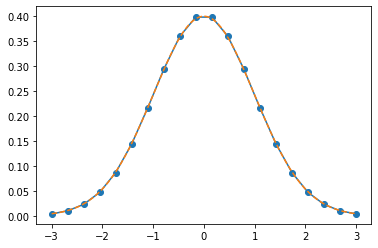

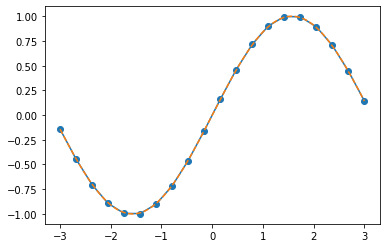

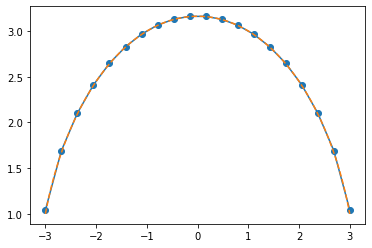

In [110]:
#TESTS
#Normal distribution function
f = lambda x: (1/np.sqrt(2*np.pi))*np.exp((-x**2)/2)

Xs = np.linspace(-3,3,1000)
Ys = f(Xs)

X1 = np.linspace(-3.0,3,20)
alpha1 = L2(f,X1)
plt.plot(X1,alpha1,'-o')
plt.plot(Xs,Ys,'--')
print("Norm with 20 pts:",np.linalg.norm(f(X1)-alpha1))

X2 = np.linspace(-3.0,3,40)
alpha2 = L2(f,X2)
print("Norm with 40 pts:",np.linalg.norm(f(X2)-alpha2))

X3 = np.linspace(-3.0,3,80)
alpha3 = L2(f,X3)
print("Norm with 80 pts:",np.linalg.norm(f(X3)-alpha3))

X4 = np.linspace(-3.0,3,160)
alpha4 = L2(f,X4)
print("Norm with 160 pts:",np.linalg.norm(f(X4)-alpha4))


#Some more functions for fun!

#Sine trigonometric function
g = lambda x: np.sin(x)

#Half circle function
h = lambda x: np.sqrt(10-x**2)

Ys2 = g(Xs)
plt.figure()
alpha1 = L2(g,X1)
plt.plot(X1,alpha1,'-o')
plt.plot(Xs,Ys2,'--')

Ys3 = h(Xs)
plt.figure()
alpha1 = L2(h,X1)
plt.plot(X1,alpha1,'-o')
plt.plot(Xs,Ys3,'--')

# **Discussion**

The projection works as expected, I think. The approximations seem to be correct at least. The $A$ matrix could (and probably should) have been implemtented as a sparse matrix. It would reduce the memory footprint of the algorithm. I wanted to reuse my old code for solving a matrix equation though, which of course used regular dense numpy matrices as input.

It was a real pain for me to wrap my head around how everything worked, and I'm glad its over...